In [ ]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q trl
!pip install -q accelerate -U

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
# Freezing the model
for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, PromptEncoderConfig, PromptTuningConfig, get_peft_model, TaskType, PromptTuningInit

config = PromptEncoderConfig(task_type="CAUSAL_LM", num_virtual_tokens=20, encoder_hidden_size=128)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 229376 || all params: 124669184 || trainable%: 0.18398772867559637


In [ ]:
data = []
prompts = []
responses = []
only_sherlock_data = []
response_lines = []
with open("context_data_all.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            # concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            # data.append(concatenated_lines)
            promptLine = "Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \"" +  f"{lines[i].strip()}" + "\""
            responseLine = f"{lines[i+1].strip()}"
            prompts.append(promptLine)
            response_lines.append(responseLine)
            responses.append("Sherlock: " + responseLine)
            only_sherlock_data.append(responseLine)
            # data.append({"Prompt": promptLine, "Response": responseLine})
            data.append("Prompt: \n" + promptLine + "\n### Response: \n" + responseLine)

In [ ]:
data[1]

'Prompt: \nRespond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. "Well -- ah - -well you could straighten up this room. It looks more like a pig sty every day."\n### Response: \nOh, very well -'

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

# train_data = [tokenizer(line) for line in train_data]
# val_data = [tokenizer(line) for line in val_data]

In [ ]:
from datasets import Dataset
train_ds = Dataset.from_dict({"text" : train_data})
val_ds = Dataset.from_dict({"text" : val_data})
print(train_ds)

Dataset({
    features: ['text'],
    num_rows: 1154
})


In [ ]:
def prompt_formatter(data):
    output_texts = []
    text = f"{data['Prompt']} \n{data['Response']}"
    output_texts.append(text)
    return output_texts

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=512,
    packing=False,
    formatting_func=prompt_formatter,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-3,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    data_collator = DataCollatorForCompletionOnlyLM("Prompt: ", tokenizer=tokenizer)
)
model.config.use_cache = False
trainer.train()

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.230000,3.821332
40,3.758300,3.478049
60,3.371200,3.110693
80,3.038700,2.709810
100,2.979500,2.492634
120,2.482100,2.415233
140,2.442300,2.396081
160,2.525600,2.375407
180,2.414600,2.361536
200,2.412200,2.359555


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=2.5320664833784106, metrics={'train_runtime': 527.7292, 'train_samples_per_second': 30.319, 'train_steps_per_second': 1.895, 'total_flos': 944047090944000.0, 'train_loss': 2.5320664833784106, 'epoch': 13.84})

In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house? "No. The evidence we've found doesn't seem to belong to one person."
### Response: On the contrary; the murder may have been perpetrated by the gang."
### Response: "I can't believe the odds they're using a mugging suspect to sneak in. The robbers must be running home after having gotten a quick visit from Doyle, or someone like Doyle would find a clue or two before she left the house."
### Response: "Hmph, the gang wouldn't


In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected? "To learn the art of theft, you must understand the techniques of a stealth man."
### Response: Is it possible to get undetected through stealth, or are there few methods to succeed? "The trick is in getting through the door through which we enter."
### Response: But these stealth techniques require strong eyes, and a skilled thief must know how to avoid approaching the trap. "Secto Leviata..."
### Response: If a thief has gone in undetected, he should have a better chance of escaping. I am willing to bet that he will gain the secret to his success."
###


In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Shelock, how would you go about solving this death?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Shelock, how would you go about solving this death? "To that end, we need to get to know you. We'll want to see if you'll cooperate. The family's living quarters are still intact, but a few candles have disappeared. It will be a while before they can leave. What can we do?"
### Response: My husband, Arthur and I have two business days off until we're back in the neighborhood. While we're there, please call for the children's teacher and his son. The teacher has the following warning:


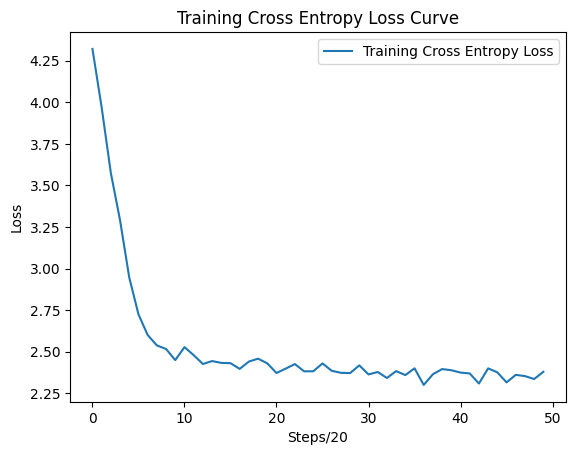

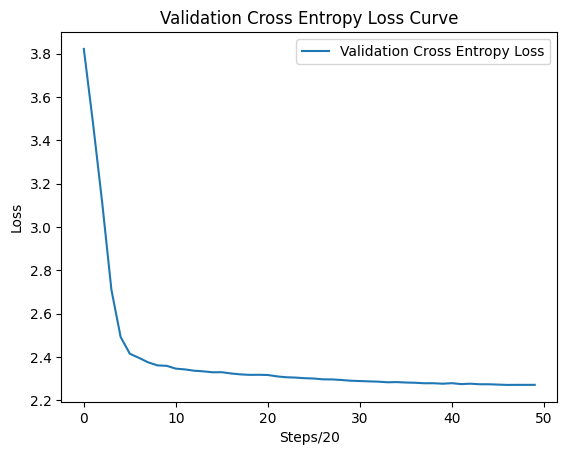

In [ ]:
import matplotlib.pyplot as plt

train_loss_values = []
val_loss_values = []

# Access the training and val loss values from the Trainer's log
for i, x in enumerate(trainer.state.log_history[:-1]):
  if (i+1) % 21 == 0:
    val_loss_values.append(x["eval_loss"])
  else:
    train_loss_values.append(x["loss"])
train_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

# Plot the training loss curve
plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

# Plot the val loss curve
plt.plot(val_loss_values, label="Validation Cross Entropy Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Validation Cross Entropy Loss Curve")
plt.legend()
plt.show()

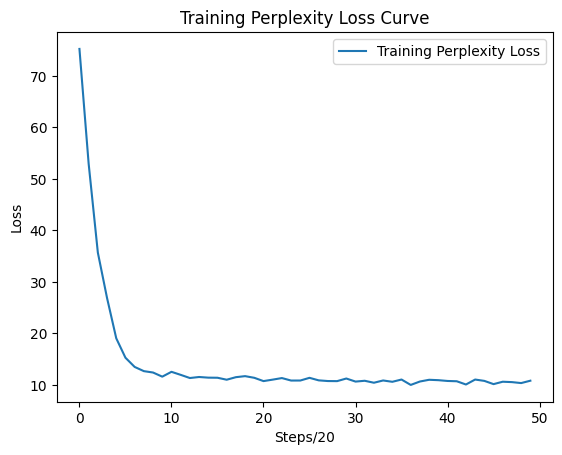

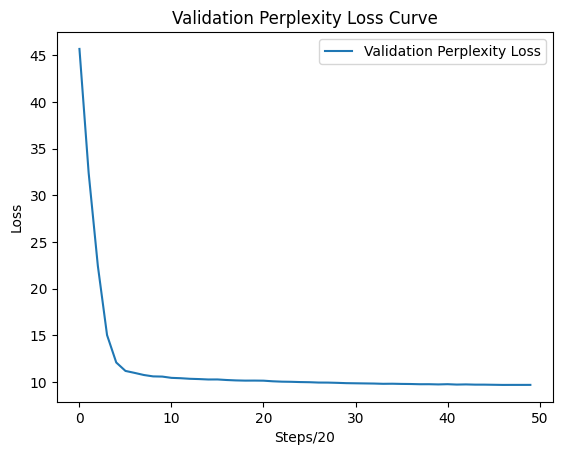

In [ ]:
import numpy as np
perplexity_train_loss_values = [np.exp(x) for x in train_loss_values]
perplexity_val_loss_values = [np.exp(x) for x in val_loss_values]

# Plot the training loss curve
plt.plot(perplexity_train_loss_values, label="Training Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Training Perplexity Loss Curve")
plt.legend()
plt.show()

# Plot the validation loss curve
plt.plot(perplexity_val_loss_values, label="Validation Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Validation Perplexity Loss Curve")
plt.legend()
plt.show()